# Possesion Chains

Actions > Position as football is a dynamic game, just because the ball is moved sideways or backwards does not mean it is a bad (i.e. negastive move). Shifting the ball like this can help teams unlock defences.

This is why we focus on possession chains:

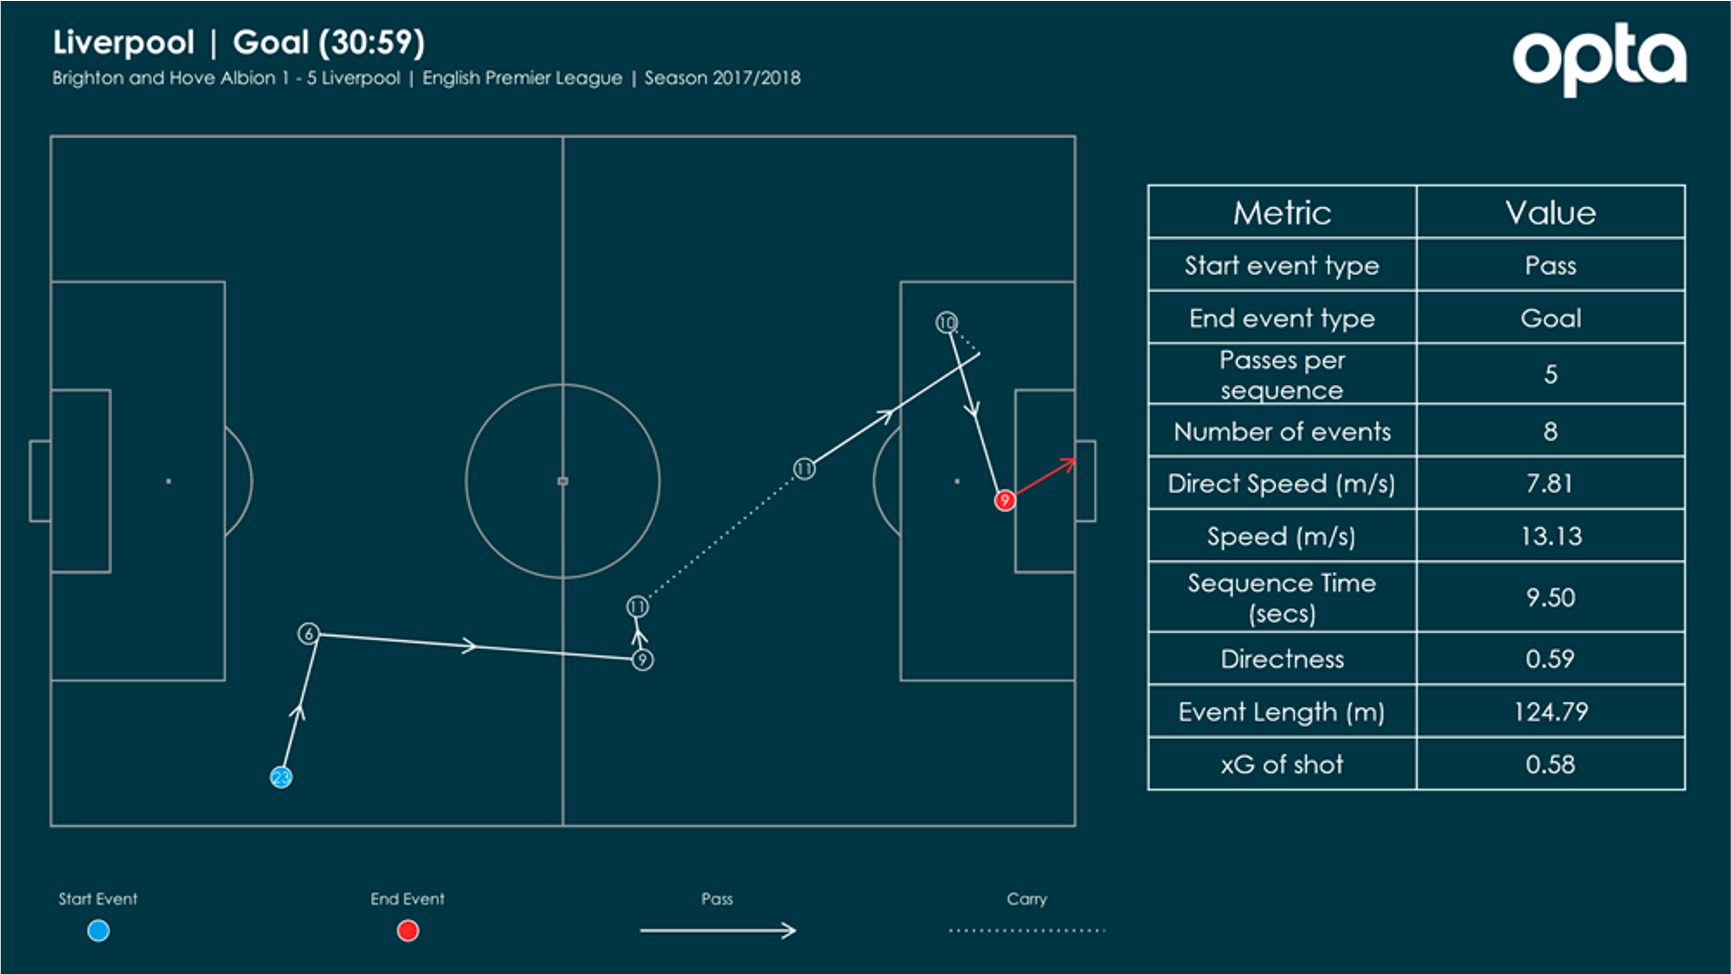

Other useful stats such as passing rate & how direct the attack is can inform understanding of different teams playing styles.

**xGChain**
- Credit every player in the chain with the xG at the end of it. Steps:
1) Find all the possession each player is in.
2) All shots within them.
3) Sum xG (max xG per possession, or shots treated as dependent events).
4) Assign that value to each player.

# Setup

In [1]:
import pandas as pd
import numpy as np
import json
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch
import matplotlib.pyplot as plt

In [2]:
notebook_directory = os.getcwd()
course_directory = ""

if os.name == "posix": 
    course_directory = notebook_directory.rsplit("/Notebooks")[0]
else:
    course_directory = notebook_directory.rsplit("\\Notebooks")[0]
os.chdir(course_directory)

# Data

## Getting Data

In [3]:
df = pd.DataFrame()

for i in range(13):
    with open(f"data/wyscout/events_England_{i+1}.json") as file:
        data = json.load(file)    
    df = pd.concat([df, pd.DataFrame(data)])

df.reset_index(drop=True, inplace=True)
df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


## Preparing the Data

In [4]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis=1)

duels = df.loc[df["eventName"] == "Duel"].copy()
lost_duels = duels.loc[duels.apply(lambda x:{'id':1802} in x.tags, axis = 1)]
df.drop(lost_duels.index, inplace=True)

out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_ball.index)

goalkepper_specific_events = df.loc[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(goalkepper_specific_events.index)

# Isolating Possesion Chains
- Chain lasts as long as the same team keeps touching the ball.

In [5]:
def isolateChains(df):
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]

    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]

    stop_criterion = 0
    chain = 0

    df["possesion_chain"] = 0
    df["possesion_chain_team"] = 0

    for i, row in df.iterrows():
        df.at[i, "possesion_chain"] = chain
        df.at[i, "possesion_chain_team"] = chain_team

        # Pass not accurate / Duel Lost -> + 1
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                stop_criterion += 1
            
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                stop_criterion += 1

        # Ball intercepted -> + 2
        if row["eventName"] == "Others on the ball":
            if row["teamId"] == row["nextTeamId"]:
                stop_criterion += 2
            
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
            stop_criterion += 2

        if row["kickedOut"] == 1:
            stop_criterion += 2

        # Stop at the end of the half
        if row["matchPeriod"] != period:
            chain += 1
            stop_criterion = 0
            chain_team = row["teamId"]
            period = row["matchPeriod"]
            df.at[i, "possesion_chain"] = chain
            df.at[i, "possesion_chain_team"] = chain_team          
            
        if stop_criterion >= 2:
            chain += 1        
            stop_criterion = 0
            chain_team = row["nextTeamId"]

    return df

In [6]:
isolated_chains_df = isolateChains(df)

# Calculating xG
- Only difference for this xG function is that penalties are treated as being shots from the penalty spot.

In [7]:
def calculate_xG(df):
    shots = df.loc[df["eventName"] == "Shot"].copy()

    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)

    shots["Goal"] = shots.tags.apply(lambda x: 1 if {"id":101} in x else 0).astype(object)
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)].copy()
    non_headers = shots.drop(headers.index)

    headers_model = smf.glm(formula="Goal ~ Distance + Angle", data=headers, family=sm.families.Binomial()).fit()
    non_headers_model = smf.glm(formula="Goal ~ Distance + Angle", data=non_headers, family=sm.families.Binomial()).fit()

    df["xG"] = 0.0
    
    b_head = headers_model.params
    xG = 1 / (1 + np.exp(b_head.iloc[0] + b_head.iloc[1] * headers["Distance"] + b_head.iloc[2] * headers["Angle"]))
    headers["xG"] = xG

    for index, row in headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    b_non_head = non_headers_model.params
    xG = 1 / (1 + np.exp(b_non_head.iloc[0] + b_non_head.iloc[1] * non_headers["Distance"] + b_non_head.iloc[2] * non_headers["Angle"]))
    non_headers["xG"] = xG

    for index, row in non_headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    penalties = df.loc[df["subEventName"] == "Penalty"].copy()
    penalties["X"] = 11
    penalties["Distance"] = 11
    penalties["Angle"] = np.arctan(7.32 * 11 / (11**2 - (7.32/2)**2))
    penalties["Goal"] = penalties.tags.apply(lambda x: 1 if {"id":101} in x else 0).astype(object)
    penalties["xG"] = xG

    for index, row in penalties.iterrows():
        df.at[index, "xG"] = row["xG"]
    
    return df

In [8]:
xG_df = calculate_xG(isolated_chains_df)
xG_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,nextTeamId,possesion_chain,possesion_chain_team,xG
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,1609,0,1609,0.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,1609,0,1609,0.000000
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,1609,0,1609,0.000000
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0,1609,0,1609,0.000000
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0,1609,0,1609,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643143,8,Cross,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",14703,"[{'y': 72, 'x': 99}, {'y': 0, 'x': 0}]",2500098,Pass,1633,2H,2789.232666,80,251596229,Touch,0,1623,113381,1633,0.000000
643144,7,Touch,[{'id': 1401}],8239,"[{'y': 31, 'x': 2}, {'y': 32, 'x': 0}]",2500098,Others on the ball,1623,2H,2790.457942,72,251596408,Ball out of the field,1,1633,113381,1633,0.000000
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232,Air duel,0,1633,113382,1633,0.000000
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234,Shot,0,1633,113382,1633,0.000000


# Chains which end in a Shot

In [9]:
def prepareChains(df):
    df["shot_end"] = 0
    no_chains = max(df["possesion_chain"].unique())
    indicies = []

    for i in range(no_chains+1):
        possesion_chain_df = df.loc[df["possesion_chain"] == i]

        if len(possesion_chain_df) > 0:
            if possesion_chain_df.iloc[-1]["eventName"] == "Shot":
                df.loc[df["possesion_chain"] == i, "shot_end"] = 1
                xG = possesion_chain_df.iloc[-1]["xG"]
                df.loc[df["possesion_chain"] ==i, "xG"] = xG
                k = i-1

                if k > 0:
                    try:
                        previous_chain = df.loc[df["possesion_chain"] == k]
                        while previous_chain.iloc[-1]["eventName"] == "Foul":
                            df.loc[df["possesion_chain"] == k, "xG"] = xG
                            df.loc[df["possesion_chain"] == k, "shot_end"] = 1
                            k = k-1
                            previous_chain = df.loc[df["possesion_chain"] == k]
                    except:
                            k = k-1
    
            team_indicies = possesion_chain_df.loc[possesion_chain_df["teamId"] == possesion_chain_df.teamId.mode().iloc[0]].index.values.tolist()
            indicies.extend(team_indicies)

    df = df.loc[indicies]
    return df

In [10]:
prepared_chains_df = prepareChains(xG_df)
prepared_chains_df.loc[prepared_chains_df["possesion_chain"].isin([0])][["eventName", "possesion_chain", "xG"]]

,eventName,possesion_chain,xG
0,Pass,0,0.0
1,Pass,0,0.0
2,Pass,0,0.0
3,Pass,0,0.0
4,Pass,0,0.0
5,Pass,0,0.0


# Prepare Data for modelling
- Filter out dodgy events without end coordinates.
- Assign the correct values for x, c and y.

In [11]:
dodgy_events_removed_df = prepared_chains_df.loc[prepared_chains_df.apply(lambda x: len(x.positions) == 2, axis=1)].copy()
dodgy_events_removed_df["x0"] = dodgy_events_removed_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
dodgy_events_removed_df["c0"] = dodgy_events_removed_df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68/100)
dodgy_events_removed_df["x1"] = dodgy_events_removed_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
dodgy_events_removed_df["c1"] = dodgy_events_removed_df.positions.apply(lambda cell: abs(50 - cell[1]['y']) * 68/100)

# End of the Shot
dodgy_events_removed_df.loc[dodgy_events_removed_df["eventName"] == "Shot", "x1"] = 105
dodgy_events_removed_df.loc[dodgy_events_removed_df["eventName"] == "Shot", "c1"] = 0

dodgy_events_removed_df["y0"] = dodgy_events_removed_df.positions.apply(lambda cell: (100 - cell[0]["y"]) * 68/100)
dodgy_events_removed_df["y1"] = dodgy_events_removed_df.positions.apply(lambda cell: (100 - cell[1]["y"]) * 68/100)
dodgy_events_removed_df.loc[dodgy_events_removed_df["eventName"] == "Shot", "y1"] = 34
dodgy_events_removed_df.reset_index(drop=True, inplace=True)

In [12]:
dodgy_events_removed_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,1609,0.000000,0,51.45,0.68,32.55,19.04,34.68,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,1609,0.000000,0,32.55,19.04,53.55,17.00,14.96,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,1609,0.000000,0,53.55,17.00,36.75,14.28,17.00,19.72
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,1609,0.000000,0,36.75,14.28,43.05,30.60,19.72,3.40
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,1609,0.000000,0,43.05,30.60,75.60,25.84,3.40,8.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435129,8,High pass,[{'id': 1801}],20620,"[{'y': 89, 'x': 53}, {'y': 72, 'x': 99}]",2500098,Pass,1633,2H,2785.702032,...,113381,1633,0.000000,0,55.65,26.52,103.95,14.96,7.48,19.04
435130,8,Cross,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",14703,"[{'y': 72, 'x': 99}, {'y': 0, 'x': 0}]",2500098,Pass,1633,2H,2789.232666,...,113381,1633,0.000000,0,103.95,14.96,0.00,34.00,19.04,68.00
435131,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,...,113382,1633,0.038676,1,105.00,34.00,92.40,2.04,0.00,36.04
435132,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,...,113382,1633,0.038676,1,92.40,2.04,90.30,0.00,36.04,34.00


# Plot Examples
## Possesion Chain ending in a Shot

In [20]:
chain = dodgy_events_removed_df.loc[dodgy_events_removed_df["possesion_chain"] == 4]
passes = chain.loc[chain["eventName"] == "Pass"]
not_passes = chain.loc[chain["eventName"] != "Pass"]
shot = chain.iloc[-1]

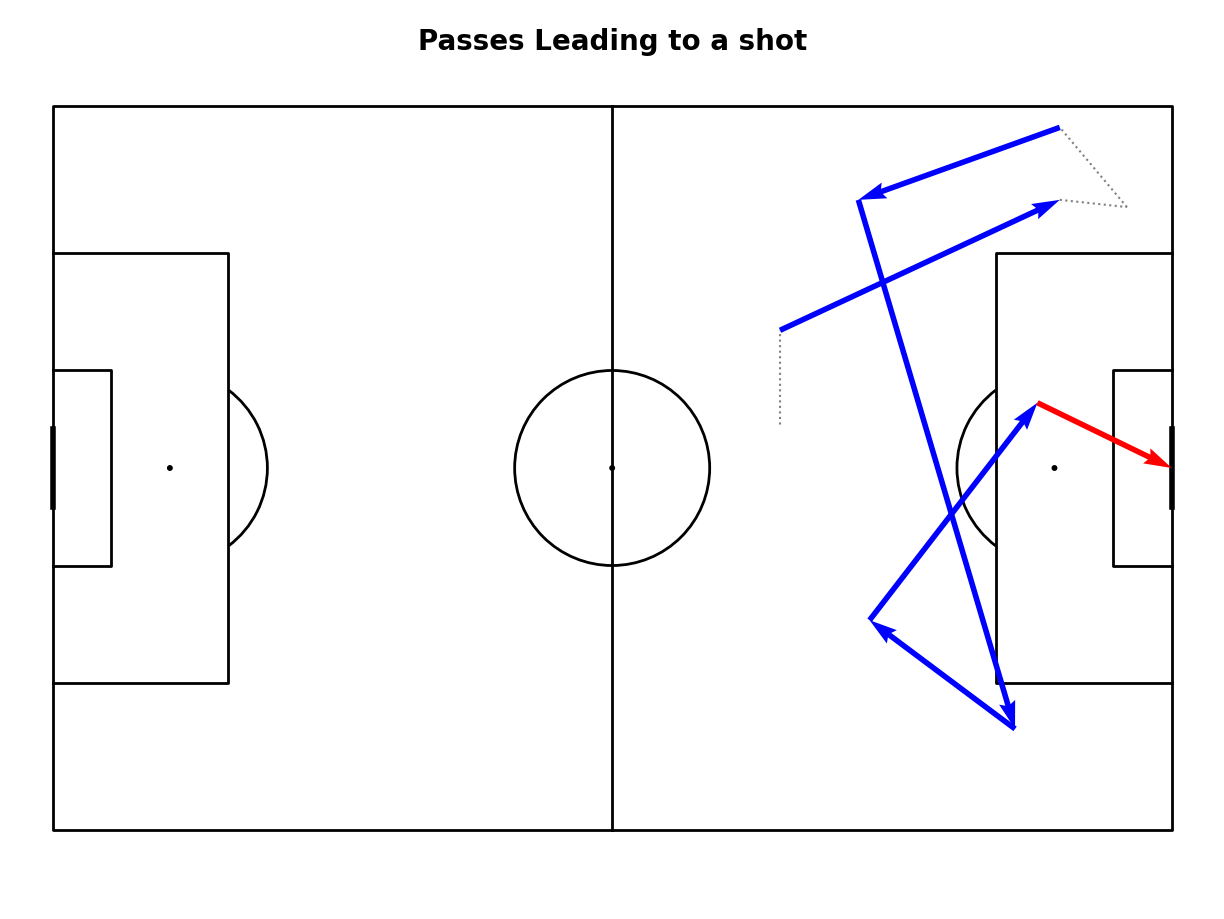

In [21]:
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

pitch.arrows(passes.x0, passes.y0, passes.x1, passes.y1, color="blue", ax=ax["pitch"], zorder=3)
pitch.arrows(shot.x0, shot.y0, shot.x1, shot.y1, color="red", ax=ax["pitch"], zorder=3)
pitch.lines(not_passes.x0, not_passes.y0, not_passes.x1, not_passes.y1, color="grey", lw=1.5, linestyle="dotted", ax=ax["pitch"])
plt.suptitle("Passes Leading to a shot", fontsize=20, fontweight='bold')
plt.show()

## Possesion Chain not ending in a shot

In [22]:
chain = dodgy_events_removed_df.loc[dodgy_events_removed_df["possesion_chain"] == 0]

passes = chain.loc[chain["eventName"].isin(["Pass", "Free Kick"])].iloc[:-1]
not_passes = chain.loc[(chain["eventName"] != "Pass") & (chain["eventName"] != "Free Kick")].iloc[:-1]
bad_pass = chain.iloc[-1]

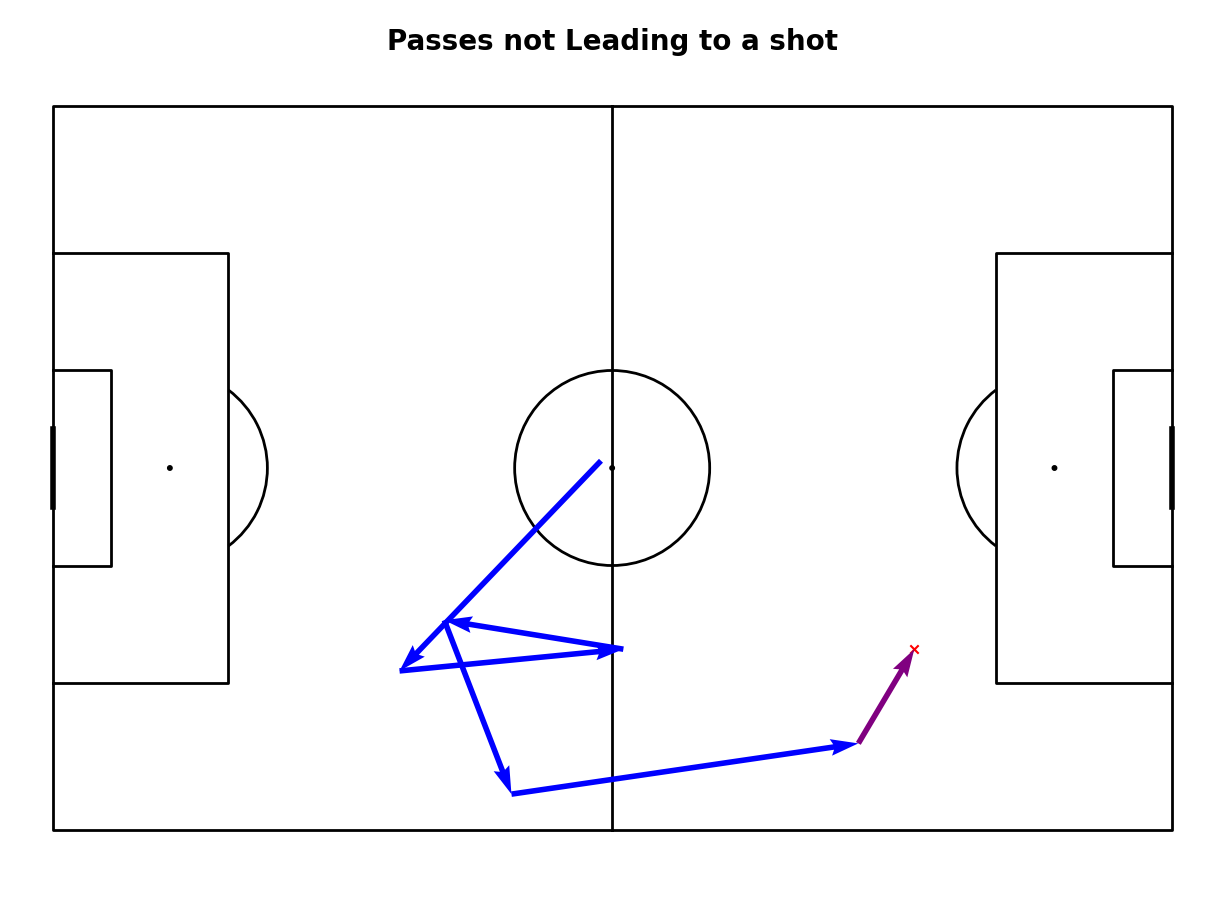

In [24]:
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

pitch.arrows(passes.x0, passes.y0, passes.x1, passes.y1, color="blue", ax=ax["pitch"], zorder=3)
pitch.arrows(bad_pass.x0, bad_pass.y0, bad_pass.x1, bad_pass.y1, color="purple", ax=ax["pitch"], zorder=3)
pitch.scatter(bad_pass.x1, bad_pass.y1, marker="x", color="red", ax=ax["pitch"])
plt.suptitle("Passes not Leading to a shot", fontsize=20, fontweight='bold')
plt.show()